In [1]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from itertools import product

import os

In [2]:
df = pd.read_csv('./res/train_df.csv')
image = cv2.imread('./res/train_imgs/001-1-1-01-Z17_A-0000001.jpg', cv2.COLOR_BGR2RGB)

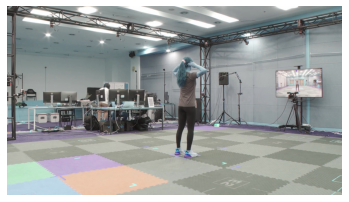

In [230]:
plt.imshow(image)
plt.axis('off')
plt.show()

In [4]:
df['x_min'] = df.iloc[:, 1:49:2].apply(lambda x: int(min(x)), axis=1)
df['x_max'] = df.iloc[:, 1:49:2].apply(lambda x: int(max(x)), axis=1)
df['y_min'] = df.iloc[:, 2:49:2].apply(lambda x: int(min(x)), axis=1)
df['y_max'] = df.iloc[:, 2:49:2].apply(lambda x: int(max(x)), axis=1)

In [5]:
df.head()

,image,nose_x,nose_y,left_eye_x,left_eye_y,right_eye_x,right_eye_y,left_ear_x,left_ear_y,right_ear_x,...,spine1(waist)_x,spine1(waist)_y,left_instep_x,left_instep_y,right_instep_x,right_instep_y,x_min,x_max,y_min,y_max
0,001-1-1-01-Z17_A-0000001.jpg,1046.389631,344.757881,1041.655294,329.820225,1059.429507,334.484230,1020.117796,338.890539,1048.000000,...,1026.515770,514.054730,998.578836,826.718013,1063.204067,838.827465,956,1134,316,838
1,001-1-1-01-Z17_A-0000003.jpg,1069.850679,340.711494,1058.608552,324.593690,1075.242111,325.593690,1041.422997,331.694815,1065.593682,...,1058.766231,508.797029,1002.265676,699.062706,1066.376234,841.499445,974,1144,323,841
2,001-1-1-01-Z17_A-0000005.jpg,1084.475902,337.000008,1078.717997,323.757889,1095.648412,325.242119,1061.039884,329.351571,1086.461032,...,1052.844144,495.890539,989.437847,808.757889,1066.071417,841.749554,984,1163,319,841
3,001-1-1-01-Z17_A-0000007.jpg,1042.320047,361.452689,1037.907194,344.117804,1050.328382,353.913729,1016.844144,340.913737,1042.164191,...,990.375124,507.624866,1001.305177,829.233767,1159.516499,599.389997,941,1159,328,829
4,001-1-1-01-Z17_A-0000009.jpg,1058.046395,343.164191,1046.717997,331.703163,1058.132650,331.781079,1031.258806,338.593690,1049.812620,...,1034.391088,510.843791,998.625231,805.218921,1059.625956,839.765102,961,1132,331,839


# Faster R-CNN

## backbone

### ResNet

In [6]:
# resnet = tf.keras.applications.resnet

### VGG

In [7]:
def get_base(img_size, model='vgg'):
    if model=='vgg':
        base_model = tf.keras.applications.VGG16(include_top=False, input_shape=img_size)
    elif model == 'resnet':
        pass
    else:
        raise Exception('vgg, resnet')
        
    base_model = tf.keras.applications.VGG16(include_top=False, weights='imagenet', input_shape=img_size)
    feature_extractor = base_model.get_layer("block5_conv3")
    base_model = tf.keras.models.Model(inputs=base_model.input, outputs=feature_extractor.output)
    return base_model

In [8]:
base_model = get_base(image.shape, model='vgg')

inputs = tf.expand_dims(image, 0)

output_map = base_model(inputs)
imgArray = output_map.numpy().squeeze(0)
# output_map

## Region Proposal Network

### Anchor boxes

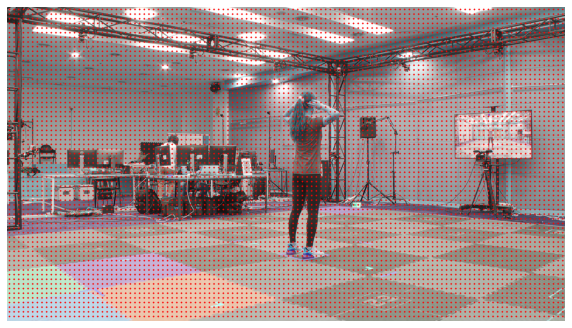

In [228]:
ratio = 2**4

w=image.shape[0]//ratio
h=image.shape[1]//ratio

img_ = np.copy(image)
plt.figure(figsize=(10, 10))
for y in range(img_.shape[0]//w//2, img_.shape[0], img_.shape[0]//w):
    for x in range(img_.shape[1]//h//2, img_.shape[1], img_.shape[1]//h):
            cv2.circle(img_, (x, y), radius=1, color=(255, 0, 0), thickness=3)
            
plt.imshow(img_)
plt.axis('off')
plt.show()

In [199]:
def anchor_box_generator(x, y):
    ratio = [(1/np.sqrt(2), np.sqrt(2)), (1, 1), (np.sqrt(2), 1/np.sqrt(2))]
    scales = [128, 256, 512]
    anchor_boxes = []
    for scale in scales:
        for w, h in ratio:
            w *= scale
            h *= scale
            anchor_boxes.append([x, y, w, h])
    return anchor_boxes

In [219]:
def Anchor_Boxes(img_shape=(1080, 1920), model='vgg'):
    '''
    input
    img_shape : image shape
    output 
    numpy array shape (w * h * 9, 4)
    '''
    if model == 'vgg':
        ratio = 2**4
        
    w=image.shape[0]//ratio
    h=image.shape[1]//ratio
    
    anchor_boxes = []
    for x in range(image.shape[0]//w//2, img_shape[0], image.shape[0]//w):
        for y in range(image.shape[1]//h//2, img_shape[1], image.shape[1]//h):
            anchor_boxes.append(anchor_box_generator(y, x))
    return np.array(anchor_boxes).reshape(-1, 4)

In [223]:
image.shape

(1080, 1920, 3)

In [224]:
anchor_boxes = Anchor_Boxes(img_shape=image.shape, model='vgg')

In [225]:
anchor_boxes

array([[   8.        ,    8.        ,   90.50966799,  181.01933598],
       [   8.        ,    8.        ,  128.        ,  128.        ],
       [   8.        ,    8.        ,  181.01933598,   90.50966799],
       ...,
       [1912.        , 1064.        ,  362.03867197,  724.07734394],
       [1912.        , 1064.        ,  512.        ,  512.        ],
       [1912.        , 1064.        ,  724.07734394,  362.03867197]])

In [195]:
len(image)

1080

In [193]:
coordinate_anchor_boxes = np.stack(
    [anchor_boxes[:, 0] - anchor_boxes[:, 2]/2,
    anchor_boxes[:, 0] + anchor_boxes[:, 2]/2,
    anchor_boxes[:, 1] - anchor_boxes[:, 3]/2,
    anchor_boxes[:, 1] + anchor_boxes[:, 3]/2],
    axis=1
)

In [191]:
anchor_boxes[:, 1] - anchor_boxes[:, 3]/2

array([-82.50966799, -56.        , -37.254834  , ..., 701.96132803,
       808.        , 882.98066402])

In [198]:
anchor_boxes[3296]

array([104.        ,  56.        , 181.01933598,  90.50966799])

In [196]:
index_inside = np.where(
    (anchor_boxes[:, 0] - anchor_boxes[:, 2]/2 >= 0) &
    (anchor_boxes[:, 0] + anchor_boxes[:, 2]/2 <= 1920) &
    (anchor_boxes[:, 1] - anchor_boxes[:, 3]/2 >= 0) &
    (anchor_boxes[:, 1] + anchor_boxes[:, 3]/2 <= 1080),
)[0]

print(index_inside.shape)

# only 8940 anchor boxes are inside the boundary out of 22500
valid_anchor_boxes = anchor_boxes[index_inside]
print(valid_anchor_boxes.shape)

(44210,)
(44210, 4)


In [197]:
index_inside

array([ 3296,  3305,  3314, ..., 70121, 70130, 70139], dtype=int64)

### Ground Truth Generating 

In [104]:
ground_truth = df.iloc[:,:1].copy() 
ground_truth['x_min'] = df['x_min'] - (df['x_max'] - df['x_min'])*.1
ground_truth['x_max'] = df['x_max'] + (df['x_max'] - df['x_min'])*.1
ground_truth['y_min'] = df['y_min'] - (df['y_max'] - df['y_min'])*.1
ground_truth['y_max'] = df['y_max'] + (df['y_max'] - df['y_min'])*.07

In [105]:
ground_truth['w'] = ground_truth['x_max'] - ground_truth['x_min']
ground_truth['h'] = ground_truth['y_max'] - ground_truth['y_min']
ground_truth['x'] = ground_truth['w']/2 + ground_truth['x_min']
ground_truth['y'] = ground_truth['h']/2 + ground_truth['y_min']

In [106]:
GT = np.array(ground_truth[['x', 'y', 'w', 'h']])

In [107]:
GT

array([[1045.   ,  569.17 ,  213.6  ,  610.74 ],
       [1059.   ,  574.23 ,  204.   ,  606.06 ],
       [1073.5  ,  572.17 ,  214.8  ,  610.74 ],
       ...,
       [ 866.5  ,  599.025,  601.2  ,  661.05 ],
       [ 866.5  ,  599.025,  601.2  ,  661.05 ],
       [ 877.   ,  599.025,  626.4  ,  661.05 ]])

### IoU

In [108]:
def anchor_to_coordinate(box):    
    x1 = box[0] - box[2]/2
    x2 = box[0] + box[2]/2
    y1 = box[1] - box[3]/2
    y2 = box[1] + box[3]/2
    return (x1, x2, y1, y2)

In [109]:
def coordinate_to_anxhor(box):
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = box[0] + w/2
    y = box[2] + h/2
    return (x, y, w, h)

In [110]:
def IoU(box1, box2):
    '''
    anchor ver
    '''
    box1_area = box1[2] * box1[3]
    box2_area = box2[2] * box2[3]
    
    x1 = max(box1[0] - box1[2]/2, box2[0] - box2[2]/2)
    x2 = min(box1[0] + box1[2]/2, box2[0] + box2[2]/2)
    
    y1 = max(box1[1] - box1[3]/2, box2[1] - box2[3]/2)
    y2 = min(box1[1] + box1[3]/2, box2[1] + box2[3]/2)
    
    h = max(0.0, y2 - y1 + 1)
    w = max(0.0, x2 - x1 + 1)
    
    if (w <= 0) or (h <= 0):
        return 0.0
    
    intersect = h * w
    union = box1_area + box2_area - intersect
    return intersect / union 

In [111]:
# def IoU(box1, box2):
#     '''
#     coordinate ver
#     '''
#     box1_area = (box1[1] - box1[0] + 1) * (box1[3] - box1[2] + 1)
#     box2_area = (box2[1] - box2[0] + 1) * (box2[3] - box2[2] + 1)
    
#     x1 = max(box1[0], box2[0])
#     x2 = min(box1[1], box2[1])
    
#     y1 = max(box1[2], box2[2])
#     y2 = min(box1[3], box2[3])    
    
#     h = max(0.0, y2 - y1 + 1)
#     w = max(0.0, x2 - x1 + 1)
    
#     if (w <= 0) or (h <= 0):
#         return 0.0
    
#     intersect = h * w
#     union = box1_area + box2_area - intersect
    
#     iou = intersect / union
#     return iou

In [112]:
# from joblib import Parallel, delayed

# def label_generator(gt, anchor_boxes):
#     label = np.empty(shape=(1, anchor_boxes.shape[0]))
#     max_iou = 0
#     for j in range(label.shape[1]):
#         iou = IoU(gt, anchor_boxes[j])
#         if iou >= 0.7:
#             label[0][j] = 1
#         elif iou < 0.3:
#             label[0][j] = -1
#         else:
#             label[0][j] = 0

#         if iou > max_iou:
#             tmp = j
#     label[0][tmp] = 1
#     return label.tolist()

# n_jobs=2
# parallel = Parallel(n_jobs=n_jobs)
# ground_truths = np.array(ground_truth.iloc[:,1:])

# label = parallel(
#     delayed(label_generator)(gt=gt, anchor_boxes=anchor_boxes) 
#     for gt in tqdm(ground_truths)
# )

# label = np.array(label).reshape(-1, 72360)

### Label Generating

In [113]:
def label_generator(GT, anchor_boxes):
    label = np.empty(shape=(len(GT), anchor_boxes.shape[0]))
    for i in tqdm(range(label.shape[0])):
        gt = GT[i]
        max_iou = 0
        for j in range(label.shape[1]):
            iou = IoU(gt, anchor_boxes[j])
            if iou >= 0.7:
                label[i][j] = 1
            elif iou < 0.3:
                label[i][j] = -1
            else:
                label[i][j] = 0
                
            if iou > max_iou:
                tmp = i, j
                
        label[tmp[0]][tmp[1]] = 1
    return label    

In [405]:
labels = label_generator(GT, anchor_boxes)

100%|██████████████████████████████████████████████████████████████████████████████| 4195/4195 [21:39<00:00,  3.23it/s]


In [444]:
labels.shape

(4195, 18360)

In [445]:
n = 18
print(sum(labels[n] == -1), sum(labels[n] == 0), sum(labels[n] == 1))

17919 427 14


In [447]:
n = 1
print(sum(labels[n] == -1), sum(labels[n] == 0), sum(labels[n] == 1))

18161 198 1


### Region Proposal Network

In [22]:
class RPN(tf.keras.layers.Layer):
    def __init__(self, img_size, k=9, backbone='vgg',**kwargs):
        super(RPN, self).__init__(**kwargs)
        self.backbone = backbone
        self.img_size = img_size
        self.k = k
        self.base_model = get_base(self.img_size, model=self.backbone)
        self.window = tf.keras.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding='same')
        self.bounding = tf.keras.layers.Conv2D(filters=self.k*4, kernel_size=1, activation='sigmoid')
        self.cls = tf.keras.layers.Conv2D(filters=self.k, kernel_size=1, activation='relu')
     
    def call(self, inputs):
        feature_extractor = self.base_model(inputs)
        intermediate = self.window(feature_extractor)
        cls_ = self.cls(intermediate)
        bounding_ = self.bounding(intermediate)
        return cls_, bounding_

In [23]:
rpn = RPN(img_size=image.shape, k=9, backbone='vgg')
cls, bounding = rpn(inputs)

In [24]:
cls.shape

TensorShape([1, 67, 120, 9])

In [25]:
tf.keras.layers.Reshape((-1, 9))(cls).shape

TensorShape([1, 8040, 9])

In [26]:
bounding.shape

TensorShape([1, 67, 120, 36])

In [27]:
tf.keras.layers.Reshape((-1, 4, 9))(bounding).shape

TensorShape([1, 8040, 4, 9])

## Detector

### Non-Maximum Suppression

In [95]:
iou = []
qq = np.array(GT)[0]
for box in anchor_boxes:
    iou.append(IoU(qq, box))
iou = np.array(iou)

In [96]:
selected_indices = tf.image.non_max_suppression(anchor_boxes, iou, max_output_size=128, score_threshold=0.01)
# tf.gather(anchor_boxes, selected_indices)

In [97]:
for i, j in zip(iou[np.array(selected_indices)][:5], tf.gather(anchor_boxes, selected_indices)[:5]):
    print(f'{i}, \t{j}{i}')

0.5086602644910649, 	[1032.          456.          181.01933598  362.03867197]0.5086602644910649
0.5086602644910649, 	[1032.          552.          181.01933598  362.03867197]0.5086602644910649
0.5023728653744052, 	[984.         520.         362.03867197 724.07734394]0.5023728653744052
0.5023728653744052, 	[1064.          616.          362.03867197  724.07734394]0.5023728653744052
0.4567209359713382, 	[984.         664.         362.03867197 724.07734394]0.4567209359713382


In [98]:
def draw_nms(ground_truth_row, anchor_boxes, max_output_size=5):
    colors = {k: tuple(map(int, np.random.randint(0, 255, 3))) for k in range(max_output_size)}
    x1 = int(ground_truth_row['x_min'])
    x2 = int(ground_truth_row['x_max'])
    y1 = int(ground_truth_row['y_min'])
    y2 = int(ground_truth_row['y_max'])
    
    image = cv2.imread(f'./res/train_imgs/{ground_truth_row["image"]}', cv2.COLOR_BGR2RGB)
    cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), thickness=4)

    GT = ground_truth_row[['x', 'y', 'w', 'h']]
    iou = []
    for box in anchor_boxes:
        iou.append(IoU(GT, box))
    iou = np.array(iou)
    
    selected_indices = tf.image.non_max_suppression(anchor_boxes, iou, max_output_size=max_output_size, score_threshold=0.01)
    anchor_boxes = tf.gather(anchor_boxes, selected_indices)
    
    for i, anchor_box in enumerate(anchor_boxes):
        anchor_box = anchor_to_coordinate(anchor_box.numpy())
        cv2.rectangle(
            image, 
            (int(anchor_box[0]), int(anchor_box[2])), (int(anchor_box[1]), int(anchor_box[3])), 
            colors.get(i), 
            thickness=2
        )

    fig, ax = plt.subplots(dpi=200)
    ax.imshow(image)
    ax.axis('off')
    plt.show()

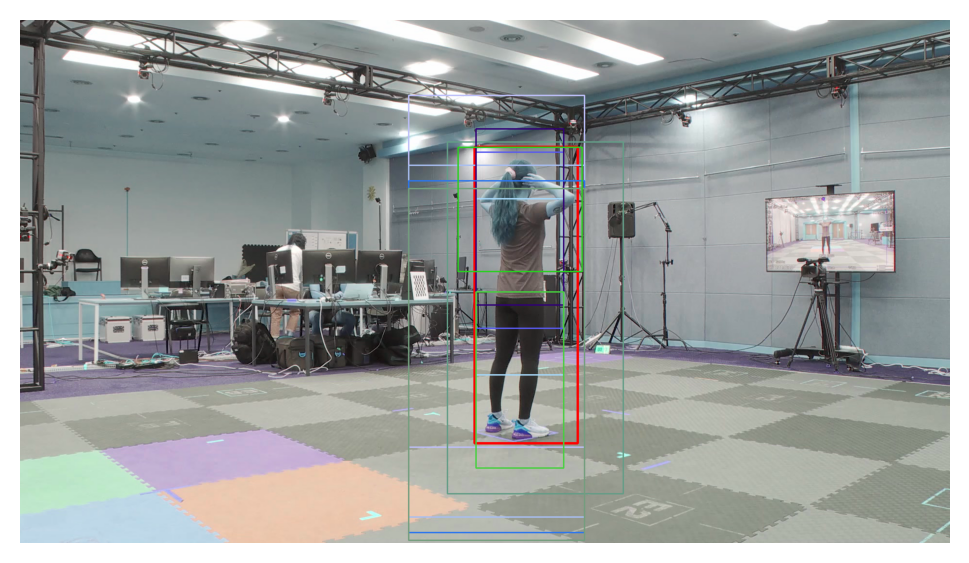

In [99]:
draw_nms(ground_truth.iloc[0], anchor_boxes, max_output_size=10)

### Regional Interest Projection

In [ ]:
class Regional_Interest_Projection(tf.keras.layers.Lyaer):
    def __init__(self, base_layer, regional_interest, **kwargs):
        super(Regional_Interest_Projection, self).__init__(**kwargs)
        self.base_layer = base_layer
        self.regional_interest = regional_interest
        
    def projection(self, x):
        pass
        
    def call(self, anchor_box):
        x = projection(anchor_box)
        return x

In [ ]:
def projection(inputs):
    pass

def Regional_Interest_Projection(feature_map, regional_interest):
    return projection(feature_map, regional_interest)

### RoI pooling

In [106]:
class RoIPooling(tf.keras.layers.Layer):
    def __init__(self, pool_size, num_rois, **kwargs):
        super(RoIPooling, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.num_rois = num_rois

    def build(self, input_shape):
        self.nb_channels = input_shape[0][3]   

    def compute_output_shape(self, input_shape):
        return (None, self.num_rois, self.pool_size, self.pool_size, self.nb_channels)

    def call(self, x):
        
        assert(len(x) == 2)

        # x[0] is image with shape (rows, cols, channels)
        img = x[0]

        # x[1] is roi with shape (num_rois,4) with ordering (x,y,w,h)
        rois = x[1]

        input_shape = tf.shape(img)

        outputs = []
        for roi_idx in range(self.num_rois):

            x = rois[0, roi_idx, 0]
            y = rois[0, roi_idx, 1]
            w = rois[0, roi_idx, 2]
            h = rois[0, roi_idx, 3]

            x = tf.keras.backend.cast(x, 'int32')
            y = tf.keras.backend.cast(y, 'int32')
            w = tf.keras.backend.cast(w, 'int32')
            h = tf.keras.backend.cast(h, 'int32')

            # Resized roi of the image to pooling size (7x7)
            rs = tf.image.resize(img[:, y:y+h, x:x+w, :], (self.pool_size, self.pool_size))
            outputs.append(rs)
                

        final_output = tf.keras.backend.concatenate(outputs, axis=0)

        # Reshape to (1, num_rois, pool_size, pool_size, nb_channels)
        final_output = tf.keras.backend.reshape(final_output, (1, self.num_rois, self.pool_size, self.pool_size, self.nb_channels))

        # permute_dimensions is similar to transpose
        final_output = tf.keras.backend.permute_dimensions(final_output, (0, 1, 2, 3, 4))

        return final_output
    
    
    def get_config(self):
        config = {'pool_size': self.pool_size,
                  'num_rois': self.num_rois}
        base_config = super(RoiPoolingConv, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [27]:
class ROIPoolingLayer(tf.keras.layers.Layer):
    def __init__(self, h, w, **kwargs):
        super(RoIPooling, self).__init__(**kwargs)
        self.h = h
        self.w = w
        
    @staticmethod
    def _pool_rois(feature_map, rois, pooled_height, pooled_width):
        def curried_pool_roi(roi):
            return ROIPoolingLayer._pool_roi(feature_map, roi,
                                             pooled_height, pooled_width)

        pooled_areas = tf.map_fn(curried_pool_roi, rois, dtype=tf.float32)
        return pooled_areas

    @staticmethod
    def _pool_roi(feature_map, roi, pooled_height, pooled_width):

        feature_map_height = int(feature_map.shape[0])
        feature_map_width = int(feature_map.shape[1])

        h_start = tf.cast(feature_map_height * roi[0], 'int32')
        w_start = tf.cast(feature_map_width * roi[1], 'int32')
        h_end = tf.cast(feature_map_height * roi[2], 'int32')
        w_end = tf.cast(feature_map_width * roi[3], 'int32')

        region = feature_map[h_start:h_end, w_start:w_end, :]

        region_height = h_end - h_start
        region_width = w_end - w_start
        h_step = tf.cast(region_height / pooled_height, 'int32')
        w_step = tf.cast(region_width / pooled_width, 'int32')

        areas = [[(
            i*h_step,
            j*w_step,
            (i+1)*h_step if i+1 < pooled_height else region_height,
            (j+1)*w_step if j+1 < pooled_width else region_width
        )
            for j in range(pooled_width)]
            for i in range(pooled_height)]

        def pool_area(x):
            return tf.math.reduce_max(region[x[0]:x[2], x[1]:x[3], :], axis=[0, 1])

        pooled_features = tf.stack([[pool_area(x) for x in row] for row in areas])
        return pooled_features
        
    def call(self, x):
        def curried_pool_rois(x):
            return ROIPoolingLayer._pool_rois(x[0], x[1],
                                              self.pooled_height,
                                              self.pooled_width)

        pooled_areas = tf.map_fn(curried_pool_rois, x, dtype=tf.float32)
        return pooled_areas
        
    def compute_output_shape(self, input_shape):
        feature_map_shape, rois_shape = input_shape
        assert feature_map_shape[0] == rois_shape[0]
        batch_size = feature_map_shape[0]
        n_rois = rois_shape[1]
        n_channels = feature_map_shape[3]
        return (batch_size, n_rois, self.pooled_height,
                self.pooled_width, n_channels)

###  Classifier

In [ ]:
class Classifie(tf.keras.layers.Layer):
    def __init__(self, base_layers, input_rois, **kwargs):
        super(Classifie, self).__init__(**kwargs)
        self.flatten = tf.keras.layers.Flatten()
        self.dense1 = tf.keras.layers.Dense()
        self.dense2 = tf.kersa.layers.Dense()
        
        self.dense3 = tf.keras.layers.Dense()
        
        self.dense4a = tf.keras.layers.Dense(activation='softmax')
        self.dense4b = tf.keras.layers.Dense()
        
    def call(self, inputs):
        x = self.flatten(inputs)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        
        softmax = self.dense4a(x)
        bbox_regressor = self.dense4b(x)

## Faster R-CNN

In [ ]:
class Faster_RCNN(tf.kersa.Model):
    def __init__(self, train_step=0, **kwargs):
        super(Faster_RCNN, self).__init__(*kwargs)
        self.rpn = RPN()
        self.rois = RoI()
        self.detector = Detector()
        self.train_step = train_step

    def compile(self, optimizer, ...):
        super(Faster_RCNN, self).compile()
        self.optimizer = optimizer
        ...
        
        self.rpn_loss_tracker = tf.keras.metrics.Mean(name='rpn_loss')
        self.detector_loss_tracker = tf.keras.metrics.Mean(name='detector_loss')
        
    def RPN_Loss(self, z):
        pass

    def Detector_Loss(self, x, z):
        pass
        
    def train_step(self, data):
        batch_size = tf.shape(data)[0]

        with tf.GradientTape() as tape:
            generated_image = self.Generating(num=batch_size)
            discriminator_loss = self.Discriminator_Loss(data, generated_image)
        grad = tape.gradient(discriminator_loss, self.discriminator.trainable_weights)
        self.discriminator_optimizer.apply_gradients(zip(grad, self.discriminator.trainable_weights))

        with tf.GradientTape() as tape:
            generated_image = self.Generating(num=batch_size)
            generator_loss = self.Generator_Loss(generated_image)
        grad = tape.gradient(generator_loss, self.generator.trainable_weights)
        self.generator_optimizer.apply_gradients(zip(grad, self.generator.trainable_weights))

        self.generator_loss_tracker.update_state(generator_loss)
        self.discriminator_loss_tracker.update_state(discriminator_loss)

        return {
            'discriminator_loss': self.discriminator_loss_tracker.result(),
            'generator_loss' : self.generator_loss_tracker.result()
        }

## Loss

### classification Loss

### bounding box regression Loss

In [260]:
def rpn_loss_regr_fixed_num(y_true, y_pred):

        # x is the difference between true value and predicted vaue
        x = y_true[:, :, :, 4 * num_anchors:] - y_pred

        # absolute value of x
        x_abs = K.abs(x)

        # If x_abs &lt;= 1.0, x_bool = 1
        x_bool = K.cast(K.less_equal(x_abs, 1.0), tf.float32)

        return lambda_rpn_regr * K.sum(
            y_true[:, :, :, :4 * num_anchors] * (x_bool * (0.5 * x * x) + (1 - x_bool) * (x_abs - 0.5))) / K.sum(epsilon + y_true[:, :, :, :4 * num_anchors])


def rpn_loss_regr(num_anchors):
    """Loss function for rpn regression
    Args:
        num_anchors: number of anchors (9 in here)
    Returns:
        Smooth L1 loss function 
                           0.5*x*x (if x_abs &lt; 1)
                           x_abx - 0.5 (otherwise)
    """
    return rpn_loss_regr_fixed_num
  
def rpn_loss_cls_fixed_num(y_true, y_pred):

            return lambda_rpn_class * K.sum(y_true[:, :, :, :num_anchors] * K.binary_crossentropy(y_pred[:, :, :, :], y_true[:, :, :, num_anchors:])) / K.sum(epsilon + y_true[:, :, :, :num_anchors])


def rpn_loss_cls(num_anchors):
    """Loss function for rpn classification
    Args:
        num_anchors: number of anchors (9 in here)
        y_true[:, :, :, :9]: [0,1,0,0,0,0,0,1,0] means only the second and the eighth box is valid which contains pos or neg anchor =&gt; isValid
        y_true[:, :, :, 9:]: [0,1,0,0,0,0,0,0,0] means the second box is pos and eighth box is negative
    Returns:
        lambda * sum((binary_crossentropy(isValid*y_pred,y_true))) / N
    """
    

    return rpn_loss_cls_fixed_num

tqdm.std.tqdm